In [ ]:
# Libraries ----
import os
import re
import sys
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append("../modules")
import plot_hoi as ph  # type: ignore
import plot_complexity as pc  # type: ignore
import plot_interactive as pi  # type: ignore
import estimate_hoi_measures as ehm  # type: ignore
import estimate_complexity_measures as ecm  # type: ignore
import estimate_synchronization_analysis as esa  # type: ignore
import estimate_complex_network_analysis as ecna  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)

## Global variables

In [2]:
log_path = "../logs"
input_path = "../input_files"
output_path = "../output_files"
input_generation_date = "2025-02-18"
x_bounds = [0, 1920]
y_bounds = [0, 1080]
t_threshold = 3600

## Load and prepare data of all tracked videos

In [3]:
cols = [
    "particles",
    "video",
    "permuted_id",
    "time",
    "position_x",
    "position_y",
    "corrected_orientation",
    "n_x",
    "n_y",
    "n_orientation",
    "norm"
]

df_final = []
for file in os.listdir(input_path):
    df = pd.read_csv(input_path + "/" + file, low_memory=False)
    df["video"] = re.sub("reviewed_", "", re.sub(".csv", "", file))
    df["particles"] = df["video"].str[0]
    df["n_x"] = df["position_x"] / x_bounds[1] - 0.5  # Normalized position in X-axis
    df["n_y"] = df["position_y"] / y_bounds[1] - 0.5  # Normalized position in Y-axis
    df["n_orientation"] = np.sin(df["corrected_orientation"])  # Normalized Orientation
    df["norm"] = (
        np.power(df["n_x"], 2)
        + np.power(df["n_y"], 2)
        + np.power(df["n_orientation"], 2)
    )
    df_final.append(df[df["time"] <= t_threshold][cols])

df_final = pd.concat(df_final, ignore_index=True)
df_final

particles              video  permuted_id  time   position_x  \
0             2  2n_0m_2f_230330_1            0     0  1657.350058   
1             2  2n_0m_2f_230330_1            1     0  1221.582078   
2             2  2n_0m_2f_230330_1            0     3  1675.103082   
3             2  2n_0m_2f_230330_1            1     3  1221.530021   
4             2  2n_0m_2f_230330_1            0     6  1675.049035   
...         ...                ...          ...   ...          ...   
43231         4  4n_4m_0f_230523_2            3  3597   411.256103   
43232         4  4n_4m_0f_230523_2            0  3600   244.905086   
43233         4  4n_4m_0f_230523_2            1  3600   315.592605   
43234         4  4n_4m_0f_230523_2            2  3600   923.548563   
43235         4  4n_4m_0f_230523_2            3  3600   412.479307   

       position_y  corrected_orientation       n_x       n_y  n_orientation  \
0       59.069803               1.473471  0.363203 -0.445306       0.995268   
1       92.427967              -1.507389  0.136241 -0.414419      -0.997990   
2       58.309940               1.546517  0.372450 -0.446009       0.999705   
3       92.132771              -1.512559  0.136214 -0.414692      -0.998305   
4       58.351203               1.544728  0.372421 -0.445971       0.999660   
...           ...                    ...       ...       ...            ...   
43231  541.839636              -0.028980 -0.285804  0.001703      -0.028976   
43232  574.666178               3.103433 -0.372445  0.032098       0.038151   
43233  783.672704               2.764931 -0.335629  0.225623       0.367818   
43234  321.790707               0.997767 -0.018985 -0.202046       0.840262   
43235  537.647846               0.062069 -0.285167 -0.002178       0.062030   

           norm  
0      1.320771  
1      1.186289  
2      1.337054  
3      1.187136  
4      1.336909  
...         ...  
43231  0.082527  
43232  0.141201  
43233  0.298842  
43234  0.747223  
43235  0.085173  

[43236 rows x 11 columns]

## Plot time series of each individual

In [4]:
pi.interactive_plot(df=df_final, interval_size=600)

# Are there higher-order interactions in 3 and 4 cockroach videos?

- Aim: To classify regimes as redundancy-dominated or synergy-dominated over time.
- Data: Distances from the center of the box and orientation of the cockroaches respect to the vertical.

## Get O-information data between individuals
O-Information is a measure used in information theory to quantify **high-order interactions** in multivariate systems. It distinguishes between redundant and synergistic information sharing across multiple variables.

### **Mathematical Formulation**

For a set of random variables \(\{ X_1, X_2, ..., X_N \}\), the O-Information is defined as:

\begin{equation}
    \Omega(X_1, X_2, ..., X_N) = \sum_{i=1}^{N} I(X_i; \mathbf{X}_{-i}) - I(\mathbf{X}_1, ..., \mathbf{X}_N)
\end{equation}

where:

- $I(X_i; \mathbf{X}_{-i})$ is the mutual information between \(X_i\) and the rest.
- $I(\mathbf{X}_1, ..., \mathbf{X}_N)$ is the total multivariate mutual information.
- If $\Omega>0$, the system is redundancy-dominated.
- If $\Omega<0$, the system is synergy-dominated.


In [ ]:
window_sizes = [
    # [30], [36], [45], [48], [60], [72], [75], [90],
    # [120], [144], [150], [180], [225],
    # [240], [300], [360], [450], [600],
    [720], [900], [1200], [1800], [t_threshold]
]
df_oinfo = []
for video in df_final["video"].unique():
    df = df_final[df_final["video"] == video]
    if int(video[0]) >= 3:
        df_aux = ehm.estimate_oinfo_multiple_windows(
            df=df,
            window_sizes=window_sizes,
            log_path=log_path,
            log_filename="log_hoi",
            verbose=1,
            tqdm_bar=True
        )
        df_oinfo.append(df_aux)

df_oinfo = pd.concat(df_oinfo, ignore_index=True)
df_oinfo.to_csv("df_hoi.csv", index=False)
df_oinfo

100%|█████████████████████████| 9/9 [00:44<00:00,  4.99s/it]


video      t_range  size multiplet  oinfo_distance  \
0    3n_0m_3f_230404_1      0 - 300   300       012       -0.007997   
1    3n_0m_3f_230404_1    300 - 600   300       012        0.015463   
2    3n_0m_3f_230404_1    600 - 900   300       012        0.016166   
3    3n_0m_3f_230404_1   900 - 1200   300       012        0.005260   
4    3n_0m_3f_230404_1  1200 - 1500   300       012        0.432408   
..                 ...          ...   ...       ...             ...   
454  4n_4m_0f_230523_2     0 - 3600  3600       012        0.017668   
455  4n_4m_0f_230523_2     0 - 3600  3600       013       -0.052032   
456  4n_4m_0f_230523_2     0 - 3600  3600       023        0.053678   
457  4n_4m_0f_230523_2     0 - 3600  3600       123       -0.009590   
458  4n_4m_0f_230523_2     0 - 3600  3600      0123        0.017460   

     oinfo_orientation  dO_info_distance  dO_info_orientation  
0             0.062294         -0.007997             0.062294  
1             0.001630          0.015462             0.001631  
2             0.012094          0.016164             0.012094  
3             0.019752          0.005261             0.019753  
4                  NaN          0.432409                  NaN  
..                 ...               ...                  ...  
454          -0.012133          0.017671            -0.012133  
455          -0.001674         -0.052031            -0.001673  
456          -0.012717          0.053677            -0.012719  
457           0.009411         -0.009588             0.009410  
458           0.007252         -0.003866            -0.012183  

[459 rows x 8 columns]

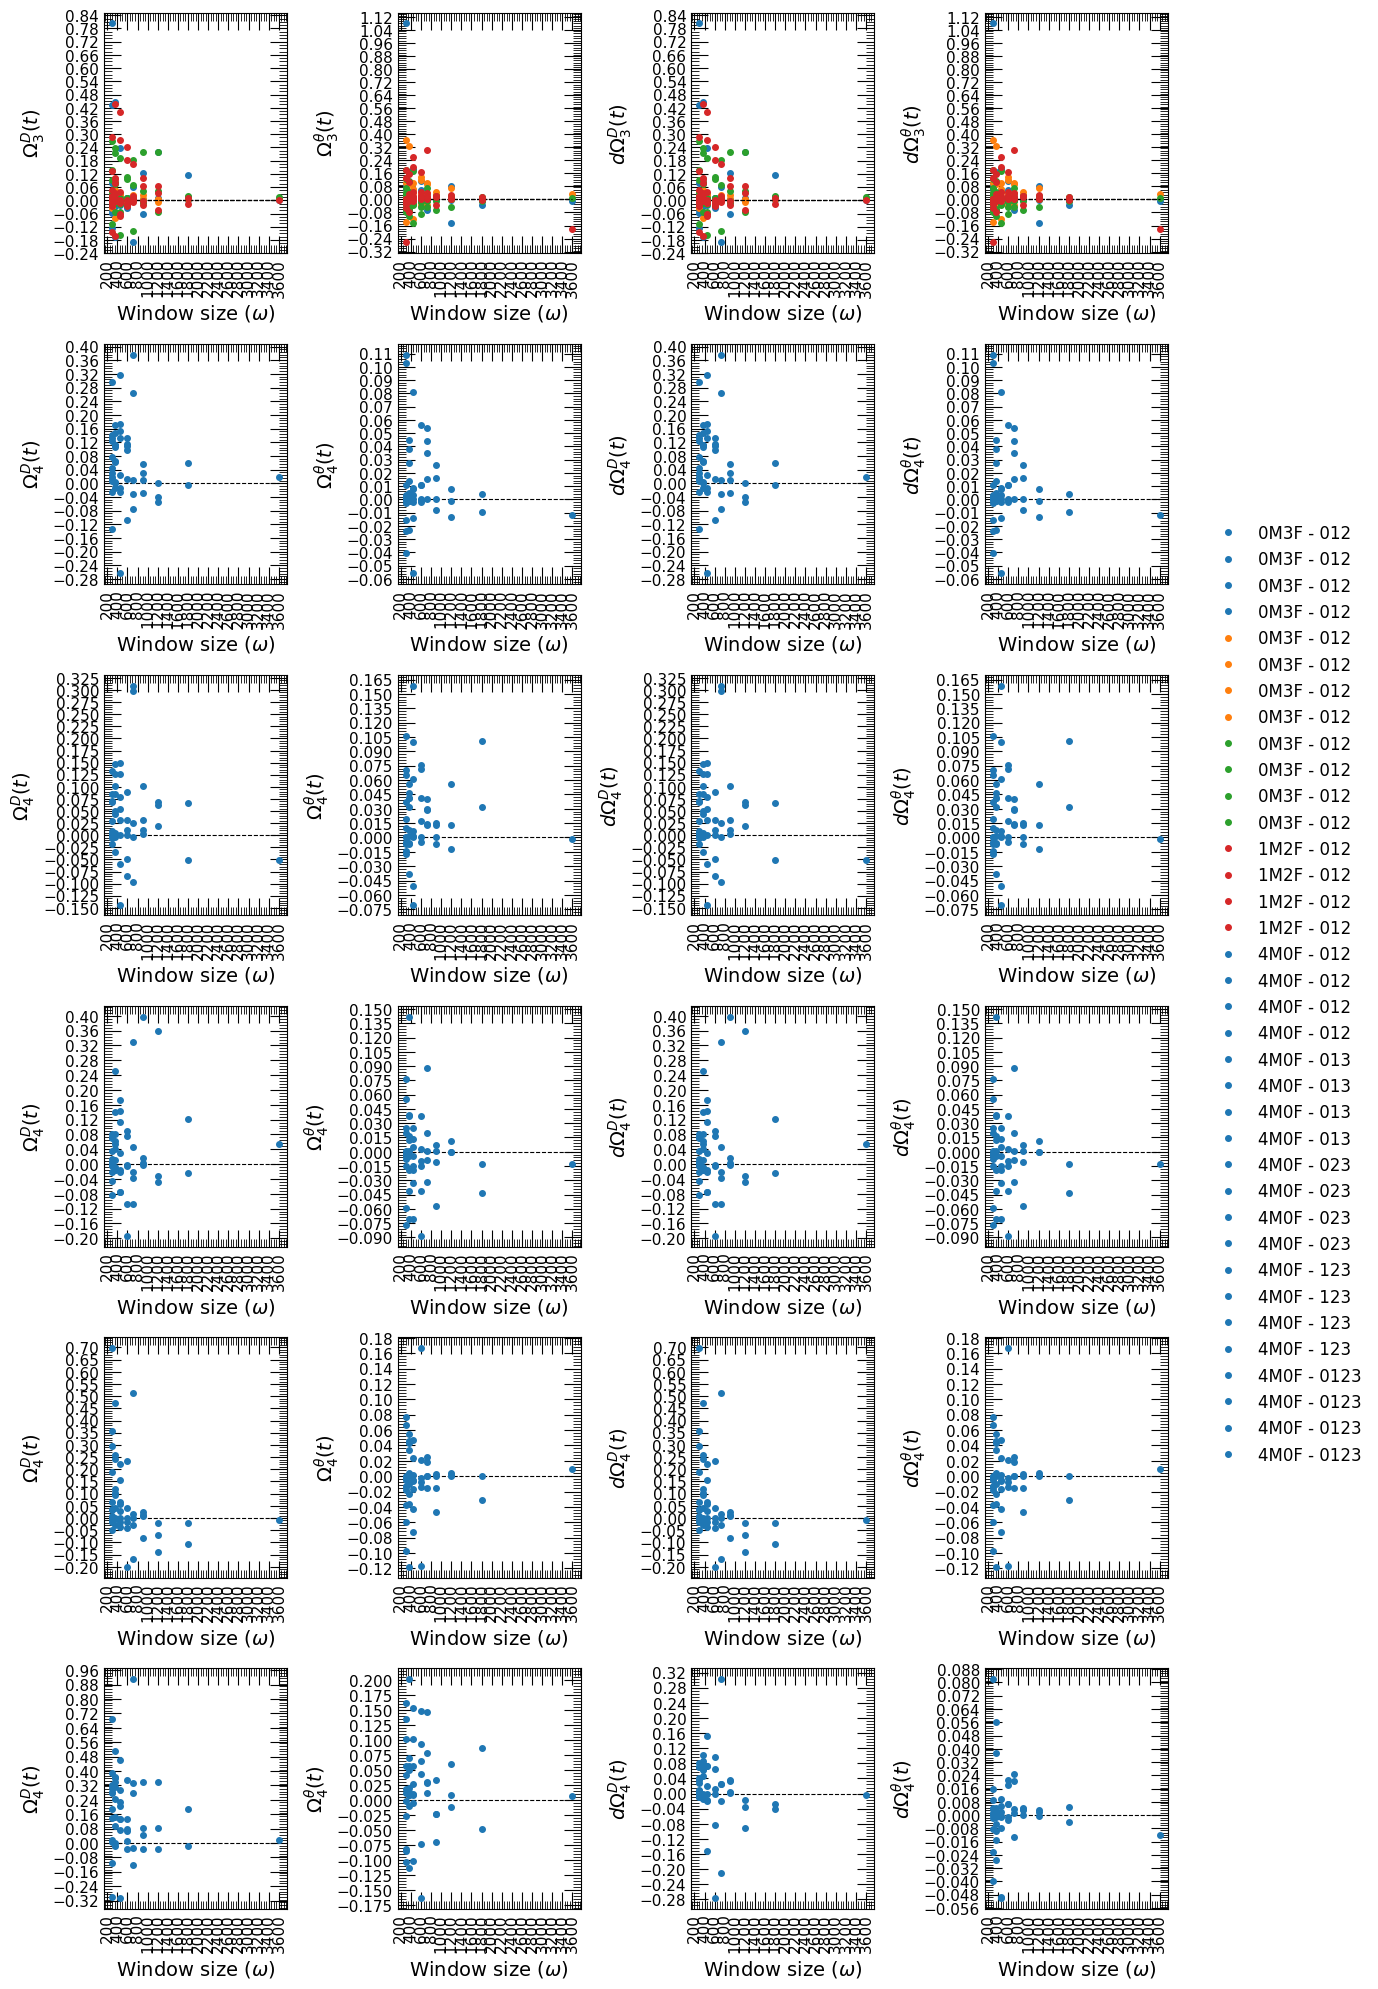

In [79]:
ax_oinfo = ph.plot_gliding_oinfo(
    df_oinfo=df_oinfo,
    width=12,
    height=20,
    n_x_breaks=20,
    n_y_breaks=20,
    fancy_legend=False,
    save_figure=False,
    output_path=output_path,
    output_name="plot_gliding_oinfo"
)

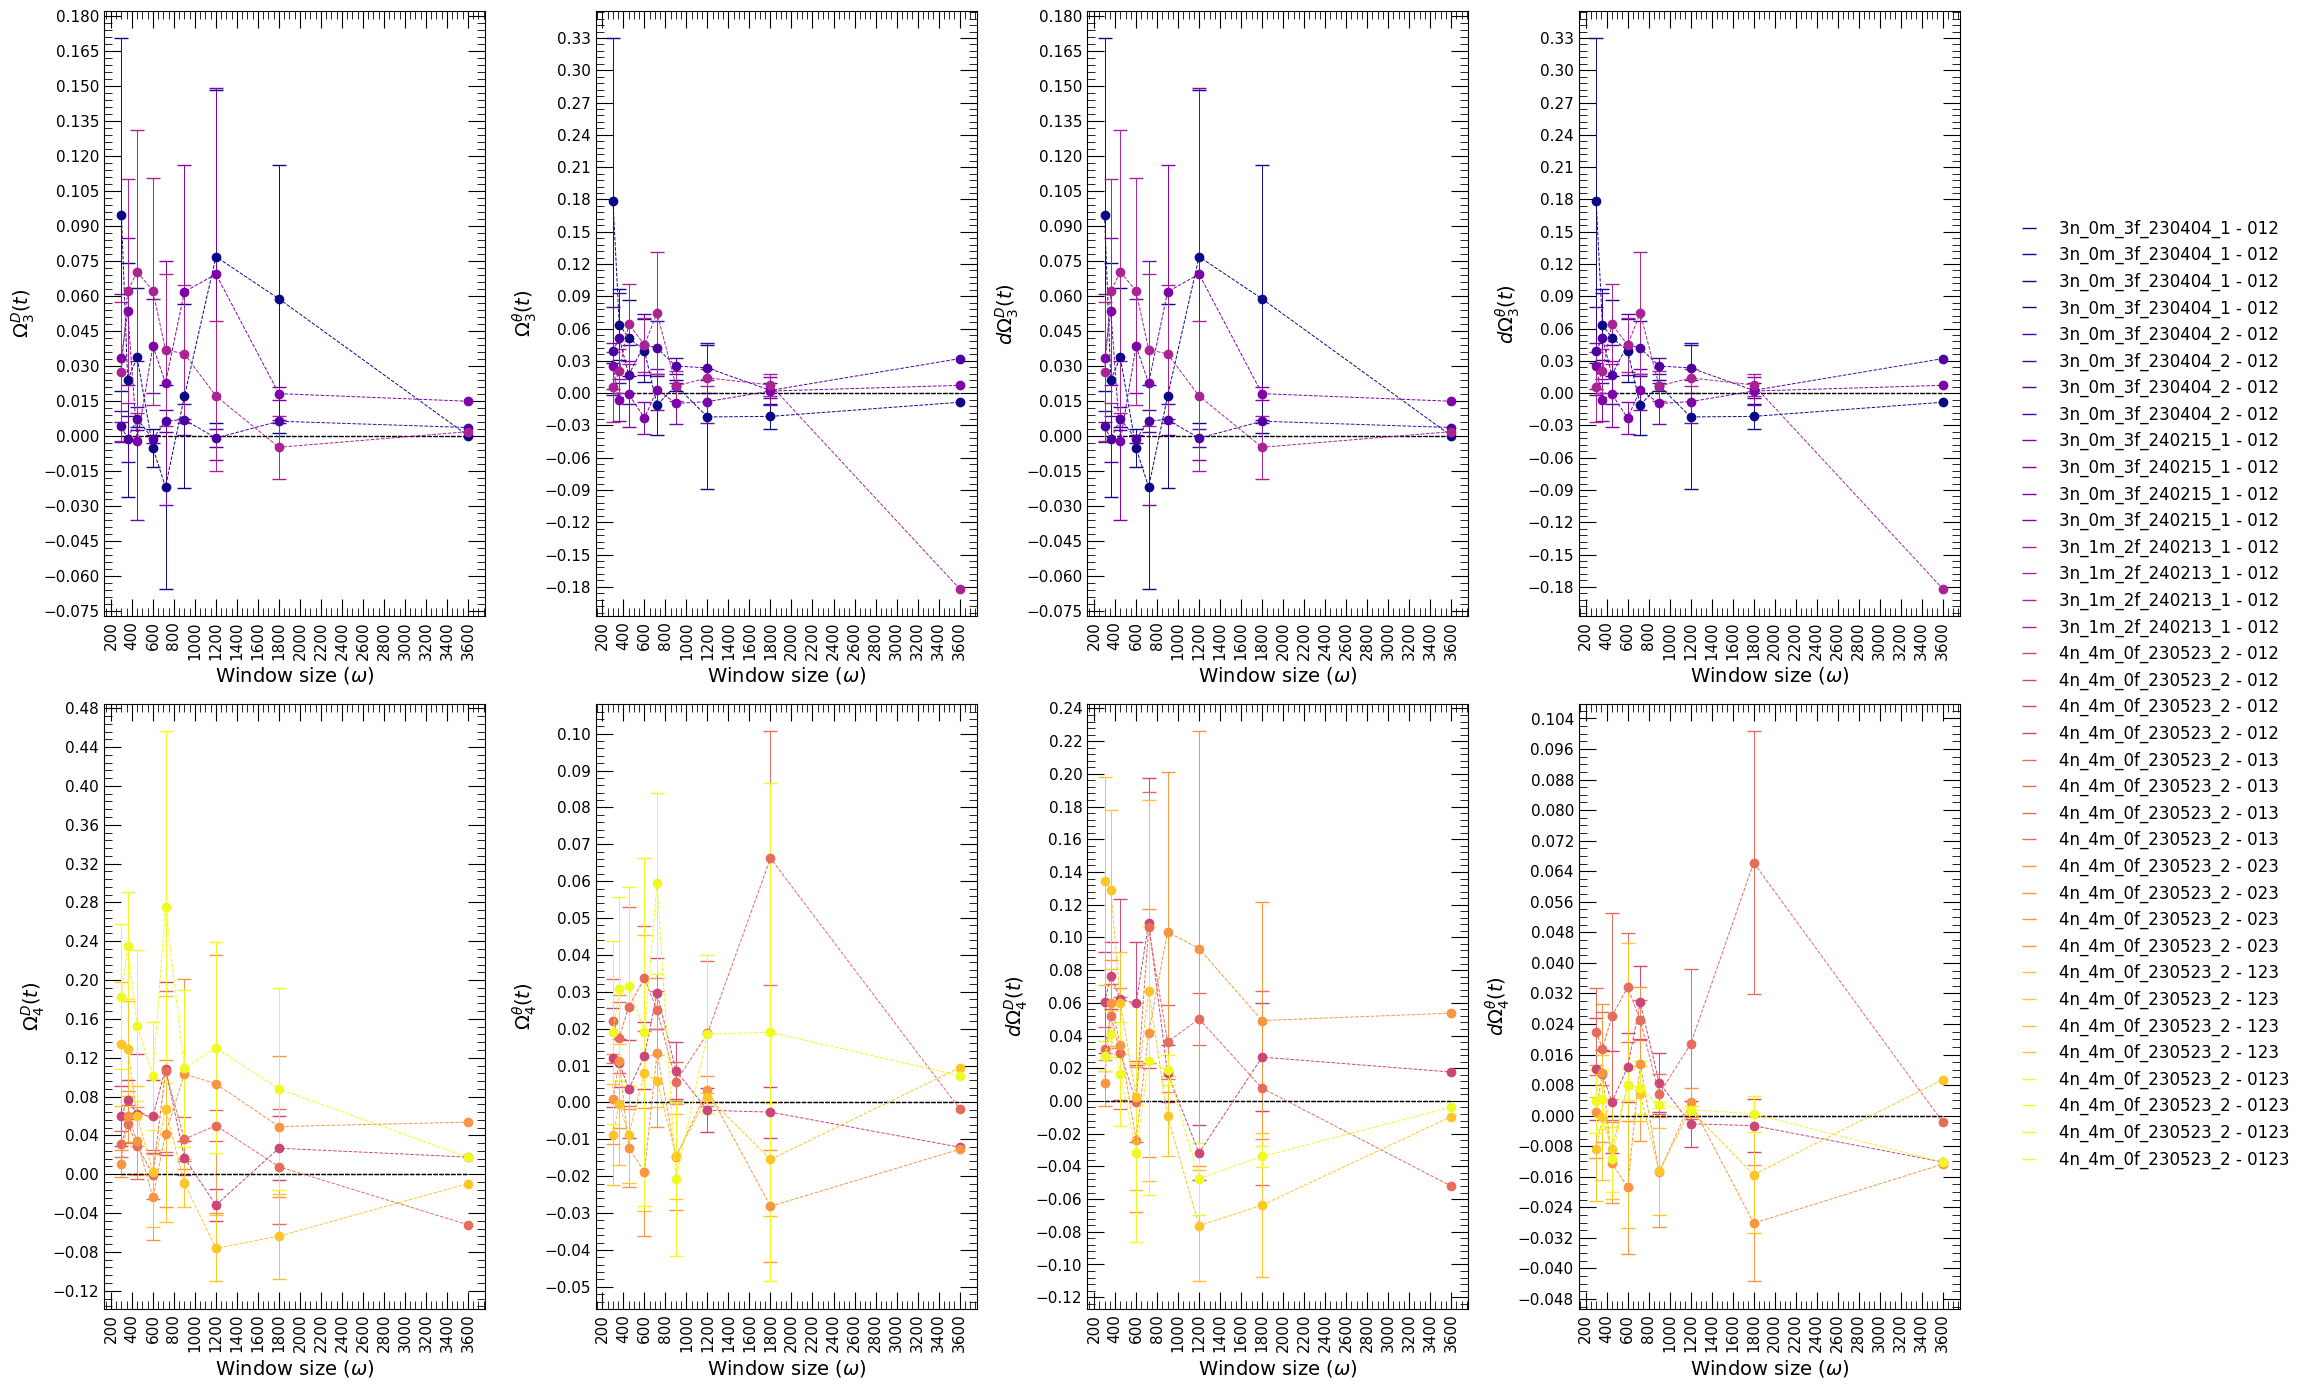

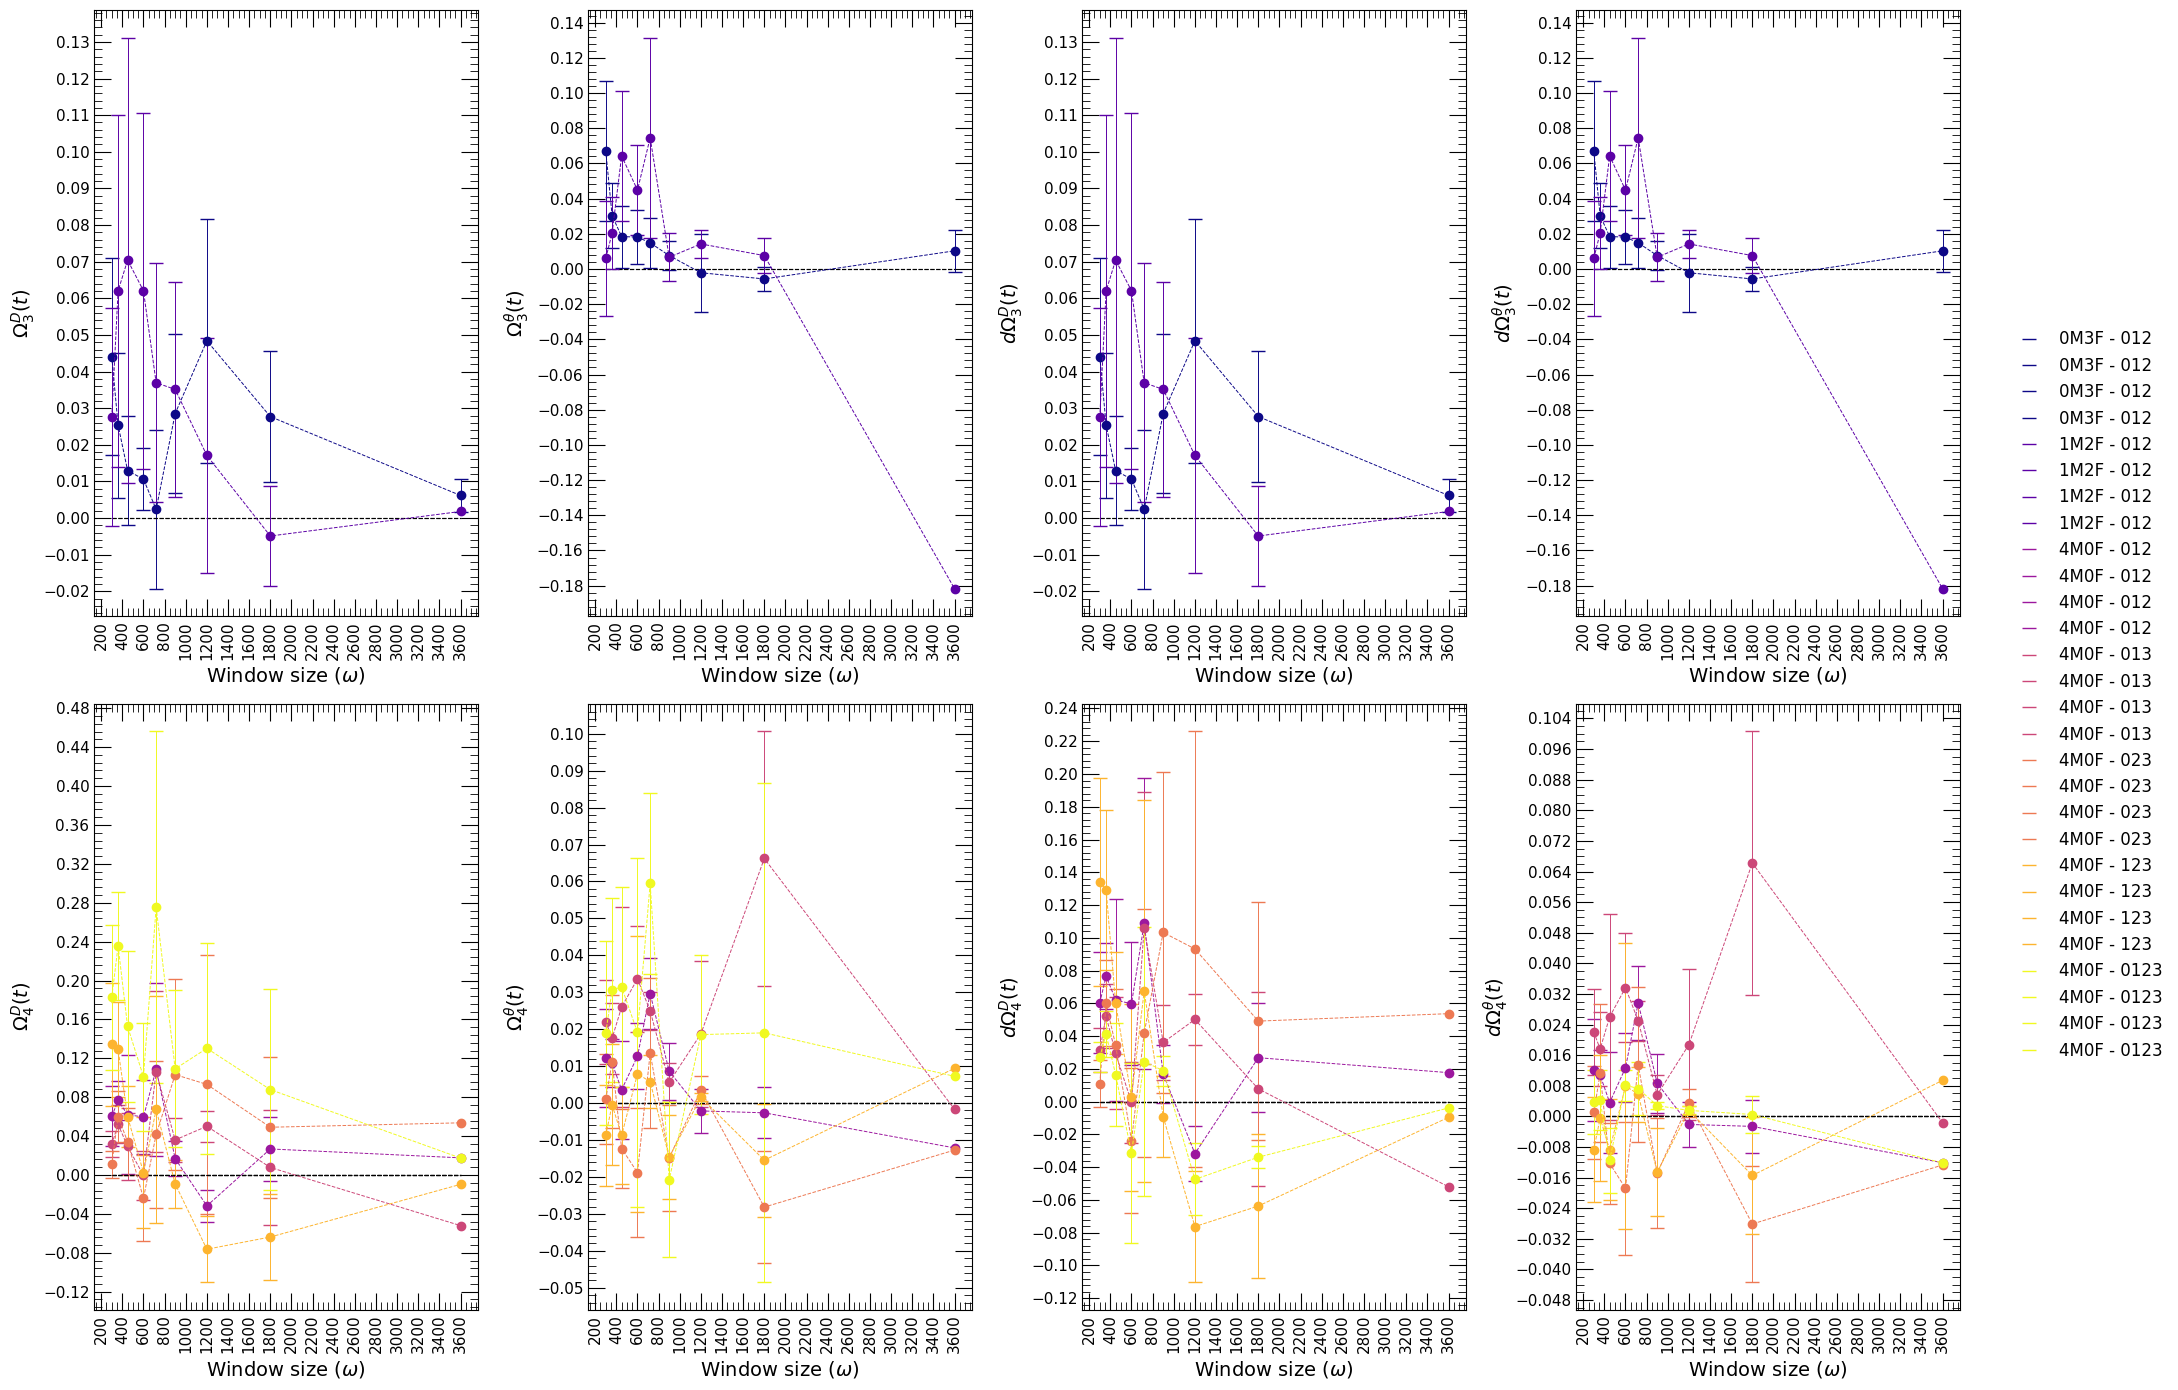

video      t_range  size multiplet  oinfo_distance  \
0    3n_0m_3f_230404_1      0 - 300   300       012       -0.007997   
1    3n_0m_3f_230404_1    300 - 600   300       012        0.015463   
2    3n_0m_3f_230404_1    600 - 900   300       012        0.016166   
3    3n_0m_3f_230404_1   900 - 1200   300       012        0.005260   
4    3n_0m_3f_230404_1  1200 - 1500   300       012        0.432408   
..                 ...          ...   ...       ...             ...   
454  4n_4m_0f_230523_2     0 - 3600  3600       012        0.017668   
455  4n_4m_0f_230523_2     0 - 3600  3600       013       -0.052032   
456  4n_4m_0f_230523_2     0 - 3600  3600       023        0.053678   
457  4n_4m_0f_230523_2     0 - 3600  3600       123       -0.009590   
458  4n_4m_0f_230523_2     0 - 3600  3600      0123        0.017460   

     oinfo_orientation  dO_info_distance  dO_info_orientation particles  \
0             0.062294         -0.007997             0.062294         3   
1             0.001630          0.015462             0.001631         3   
2             0.012094          0.016164             0.012094         3   
3             0.019752          0.005261             0.019753         3   
4                  NaN          0.432409                  NaN         3   
..                 ...               ...                  ...       ...   
454          -0.012133          0.017671            -0.012133         4   
455          -0.001674         -0.052031            -0.001673         4   
456          -0.012717          0.053677            -0.012719         4   
457           0.009411         -0.009588             0.009410         4   
458           0.007252         -0.003866            -0.012183         4   

    sex_ratio  oinfo_distance_count_1  oinfo_distance_mean_1  \
0    3n_0m_3f                      12               0.094831   
1    3n_0m_3f                      12               0.094831   
2    3n_0m_3f                      12               0.094831   
3    3n_0m_3f                      12               0.094831   
4    3n_0m_3f                      12               0.094831   
..        ...                     ...                    ...   
454  4n_4m_0f                       1               0.017668   
455  4n_4m_0f                       1              -0.052032   
456  4n_4m_0f                       1               0.053678   
457  4n_4m_0f                       1              -0.009590   
458  4n_4m_0f                       1               0.017460   

     oinfo_distance_std_1  oinfo_distance_count_2  oinfo_distance_mean_2  \
0                0.075506                      36               0.044086   
1                0.075506                      36               0.044086   
2                0.075506                      36               0.044086   
3                0.075506                      36               0.044086   
4                0.075506                      36               0.044086   
..                    ...                     ...                    ...   
454                   NaN                       1               0.017668   
455                   NaN                       1              -0.052032   
456                   NaN                       1               0.053678   
457                   NaN                       1              -0.009590   
458                   NaN                       1               0.017460   

     oinfo_distance_std_2  oinfo_orientation_count_1  \
0                0.026874                          7   
1                0.026874                          7   
2                0.026874                          7   
3                0.026874                          7   
4                0.026874                          7   
..                    ...                        ...   
454                   NaN                          1   
455                   NaN                          1   
456                   NaN                          1   
457                  

In [80]:
df_oinfo_summary, ax_oinfo_1, ax_oinfo_2 = ph.plot_hoi_metrics_summary(
    df_oinfo=df_oinfo,
    width=20,
    height=14,
    n_x_breaks=20,
    n_y_breaks=20,
    fancy_legend=False,
    save_figures=False,
    output_path=output_path,
    output_name="plot_gliding_oinfo_summary"
)
df_oinfo_summary

---
# How different is the behavior when sex ratio changes (fixed group size)?

- Aim: To estimate Hurst exponent (asses persistence), Permutation entropy (predictability), Statistical complexity (assess the balance of order and randomness) for each cockroach’s time series (distance, orientation) → persistence vs. randomness.
- Data: Distances from the center of the box and orientation of the cockroaches respect to the vertical.
---

## Get Hurst exponent, permutation entropy and Statistical complexity data between individuals

### **Mathematical Formulation**

#### 1. Hurst Exponent

The Hurst exponent ($H$) is a statistical measure used to evaluate the long-term memory of time series data. It quantifies the tendency of a time series to either:

- Persist in its trend ($H > 0.5$)
- Exhibit a random walk ($H ≈ 0.5$)
- Mean-revert (antipersistence) ($H < 0.5$)

The Hurst exponent is estimated using the rescaled range (R/S) analysis:

\begin{equation}
    H = \lim_{T \to \infty} \frac{\log(R/S)}{\log(T)},
\end{equation}

where $R$ is the range of cumulative deviations from the mean, $S$ is the standard deviation, and $T$ is the time window size.

Also, Multifractal Detrended Fluctuation Analysis (MF-DFA) is an extension of DFA (Detrended Fluctuation Analysis) that measures the **multifractal properties** of a time series by analyzing its scaling behavior at different moments $q$. The fluctuation function is defined as:

\begin{equation}
    F_q(s) = \left( \frac{1}{N_s} \sum_{\nu=1}^{N_s} F^q(\nu, s) \right)^{\frac{1}{q}}
\end{equation}

where $F(\nu, s)$ is the local detrended fluctuation at segment $\nu$, and $s$ is the window size.

#### 2. Permutation Entropy

Permutation Entropy ($PE$) is a nonlinear measure of time series complexity introduced by Bandt & Pompe (2002). It quantifies the randomness in a time series by analyzing the frequency of ordinal patterns of a given length.

Given a time series $X = \{x_1, x_2, ..., x_N\}$ and an embedding dimension $d$, we extract ordinal patterns by ranking the values within sliding windows of size $\tau$. The permutation entropy is then computed as:

\begin{equation}
    H_p = - \sum p(\pi) \log p(\pi)
\end{equation}

where $p(\pi)$ is the probability of each ordinal pattern $\pi$.

#### 3. Statistical complexity

Statistical complexity measures the balance between disorder and structure in a system. It complements entropy by identifying structured patterns within randomness.

A widely used definition is the **Jensen-Shannon complexity**, which combines permutation entropy and disequilibrium:

\begin{equation}
    C_J = H_p \cdot Q_J
\end{equation}

where $Q_J$ is the Jensen-Shannon divergence measuring disequilibrium.

---
## **References**

- Bandt, C., & Pompe, B. (2002). Permutation entropy: A natural complexity measure for time series.
- Rosso, O. A., et al. (2007). Distinguishing noise from chaos.
- Ribeiro, H. V., et al. (2012). Characterizing time series through complexity-entropy curves.
- `ordpy`: A Python library for ordinal pattern analysis.
---

In [ ]:
window_sizes = [
    # [30], [36], [45], [48], [60], [72], [75], [90],
    # [120], [144], [150], [180], [225],
    # [240], [300], [360], [450], [600],
    [720], [900], [1200], [1800], [t_threshold]
]
df_complexity = []
for video in df_final["video"].unique():
    df = df_final[df_final["video"] == video]
    df_aux = ecm.estimate_multiple_hurst_complexity(
        df=df,
        window_sizes=window_sizes,
        q=2,
        dx=3,
        taux=1,
        log_path=log_path,
        log_filename="log_complexity",
        verbose=1,
        tqdm_bar=True
    )

    df_complexity.append(df_aux)

df_complexity = pd.concat(df_complexity, ignore_index=True)
df_complexity.to_csv("df_complexity.csv", index=False)
df_complexity

100%|█████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


video      t_range  size  permuted_id  H_distance  \
0    2n_0m_2f_230330_1     0 - 1200  1200            0   -0.316029   
1    2n_0m_2f_230330_1     0 - 1200  1200            1    0.042692   
2    2n_0m_2f_230330_1  1200 - 2400  1200            0   -0.314981   
3    2n_0m_2f_230330_1  1200 - 2400  1200            1   -0.681348   
4    2n_0m_2f_230330_1  2400 - 3600  1200            0   -0.394620   
..                 ...          ...   ...          ...         ...   
211  4n_4m_0f_230523_2  1800 - 3600  1800            3    0.214942   
212  4n_4m_0f_230523_2     0 - 3600  3600            0    0.362870   
213  4n_4m_0f_230523_2     0 - 3600  3600            1    0.778787   
214  4n_4m_0f_230523_2     0 - 3600  3600            2    0.733202   
215  4n_4m_0f_230523_2     0 - 3600  3600            3    0.407086   

     PE_distance  C_distance  H_orientation  PE_orientation  C_orientation  
0       0.979235    0.020101      -0.169366        0.984680       0.014516  
1       0.939758    0.052800       0.493172        0.976648       0.021947  
2       0.997538    0.002408       0.022185        0.998105       0.001882  
3       0.977187    0.021930      -0.521319        0.981434       0.017753  
4       0.990383    0.009240      -0.003803        0.994969       0.004941  
..           ...         ...            ...             ...            ...  
211     0.951226    0.044847       0.343959        0.945015       0.049889  
212     0.955779    0.040500       0.232728        0.956867       0.039692  
213     0.880230    0.102135       0.281743        0.913399       0.076053  
214     0.903201    0.084074       0.400831        0.908576       0.079667  
215     0.938125    0.055203       0.407935        0.938068       0.055864  

[216 rows x 10 columns]

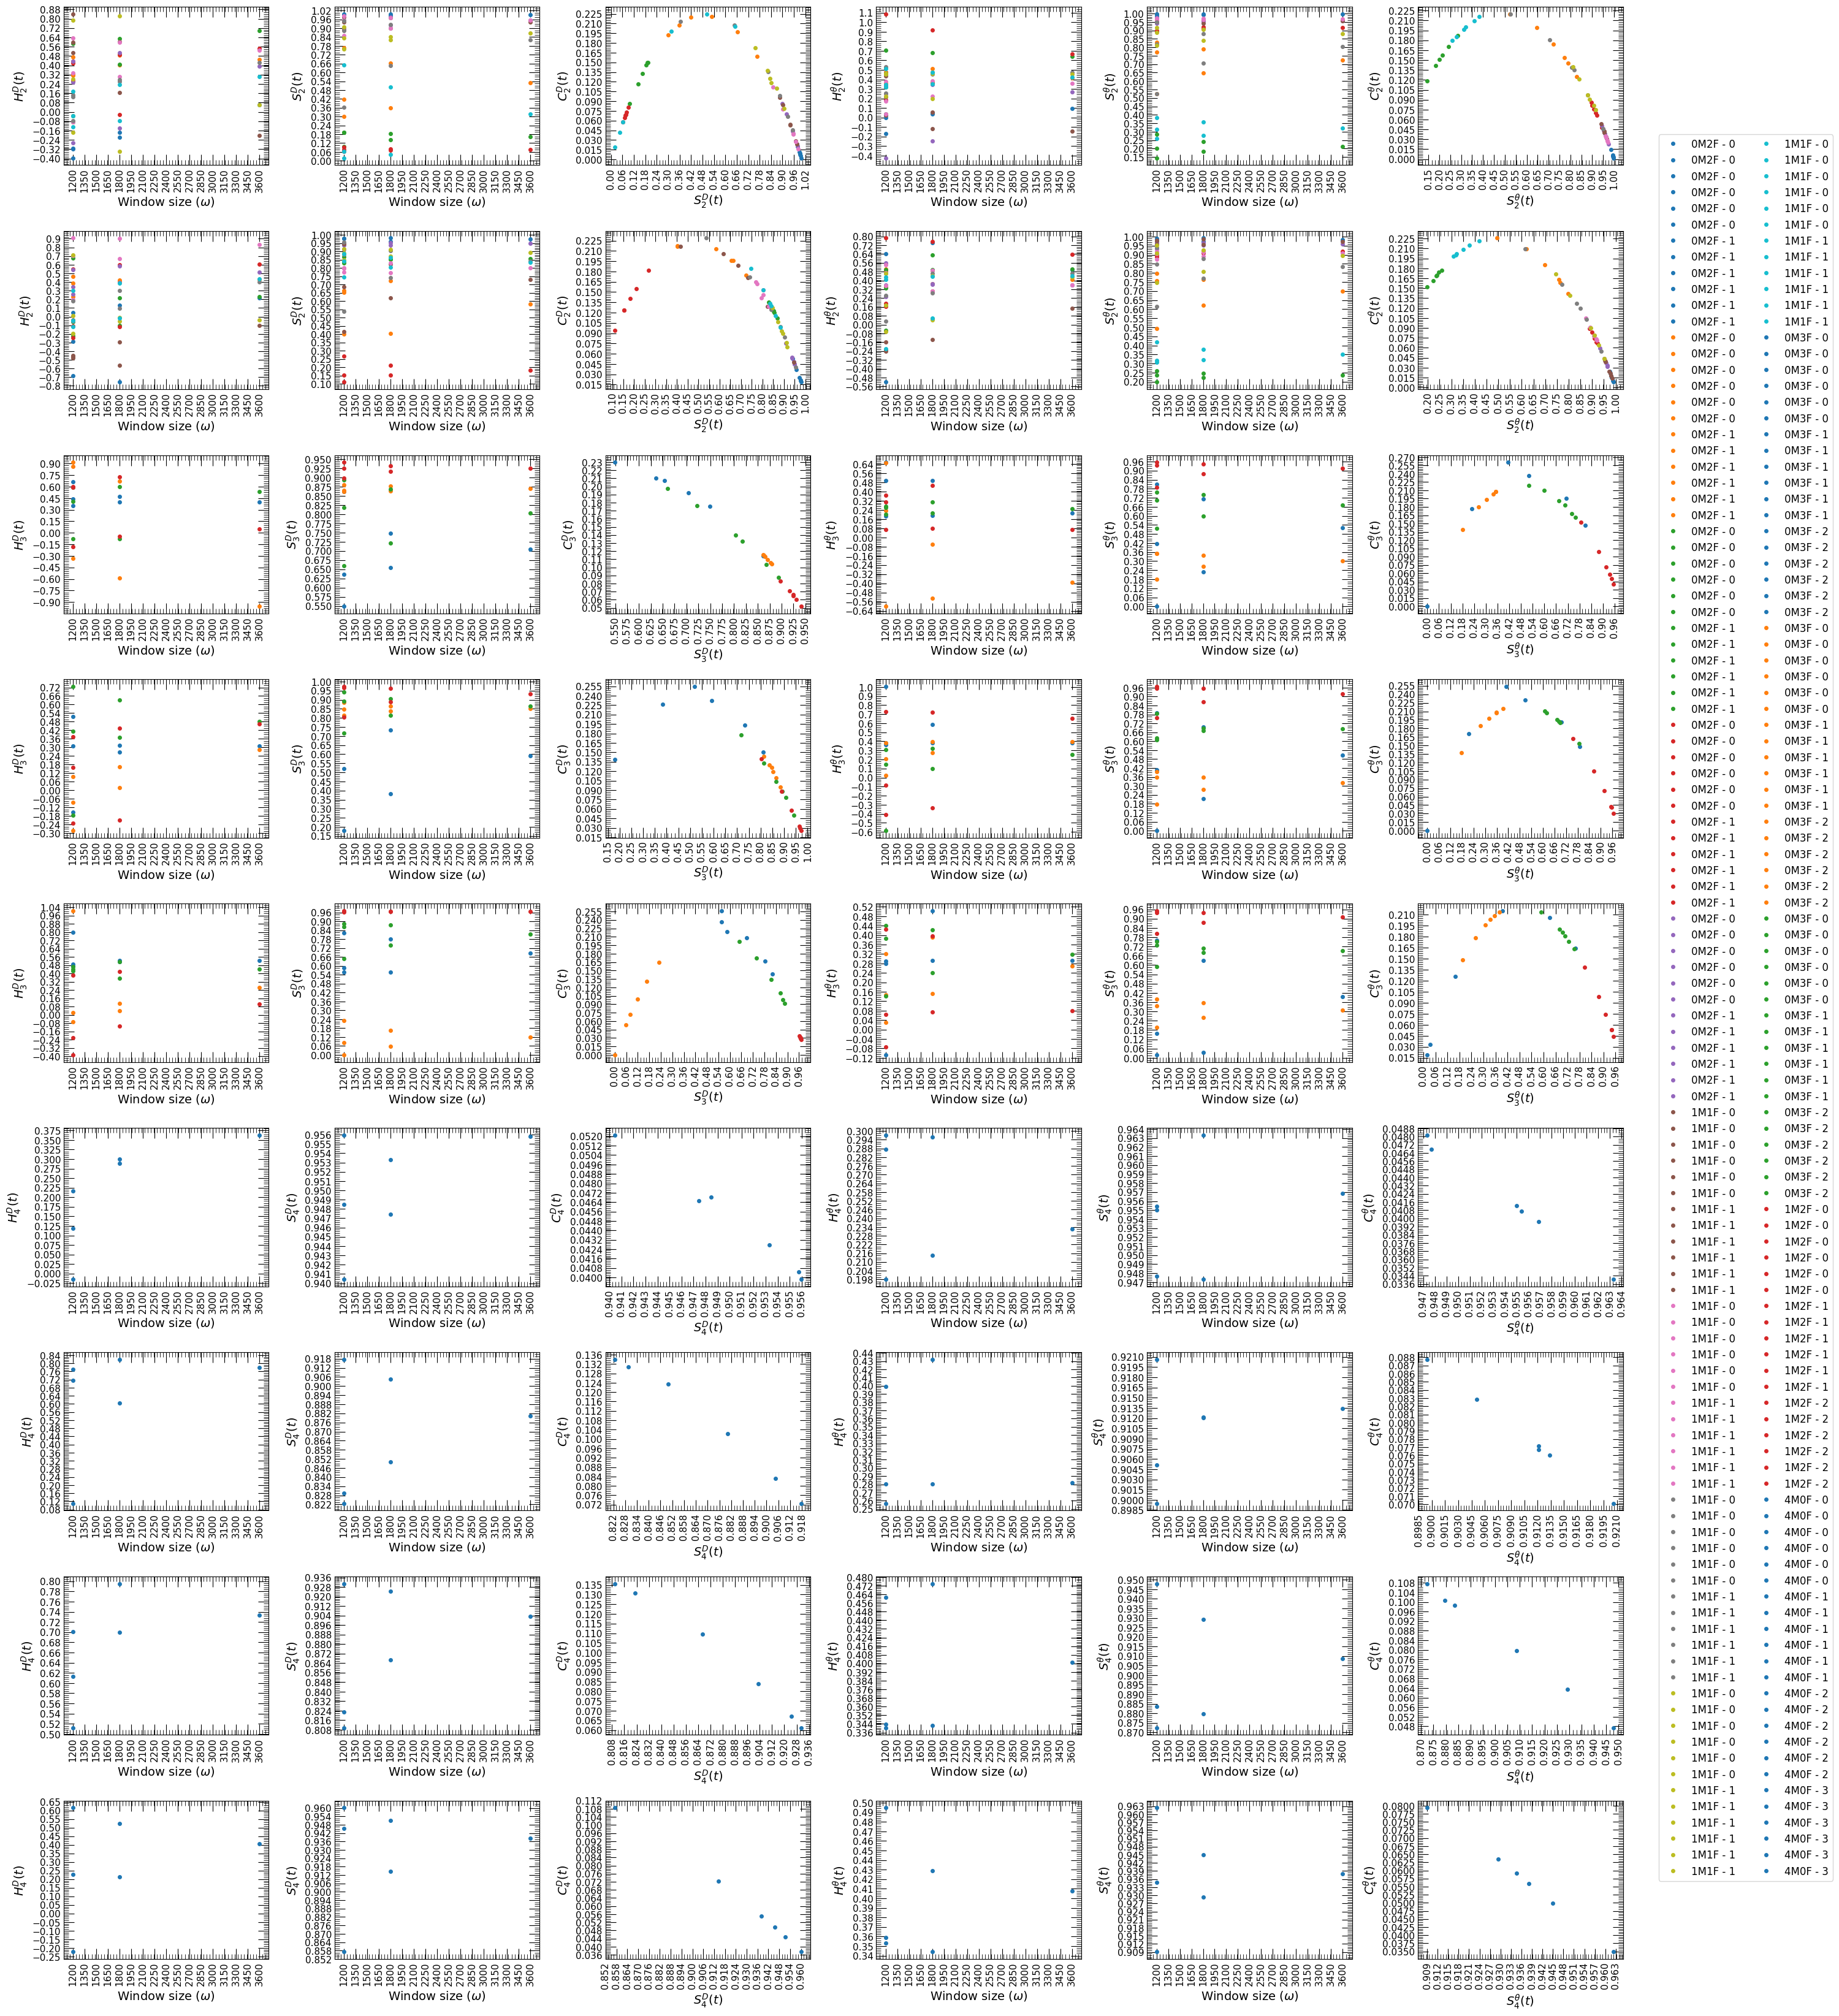

In [ ]:
ax_complexity = pc.plot_gliding_complexity(
    df_complexity=df_complexity,
    width=27,
    height=33,
    n_x_breaks=20,
    n_y_breaks=20,
    fancy_legend=False,
    save_figure=False,
    output_path=output_path,
    output_name="plot_gliding_complexity"
)

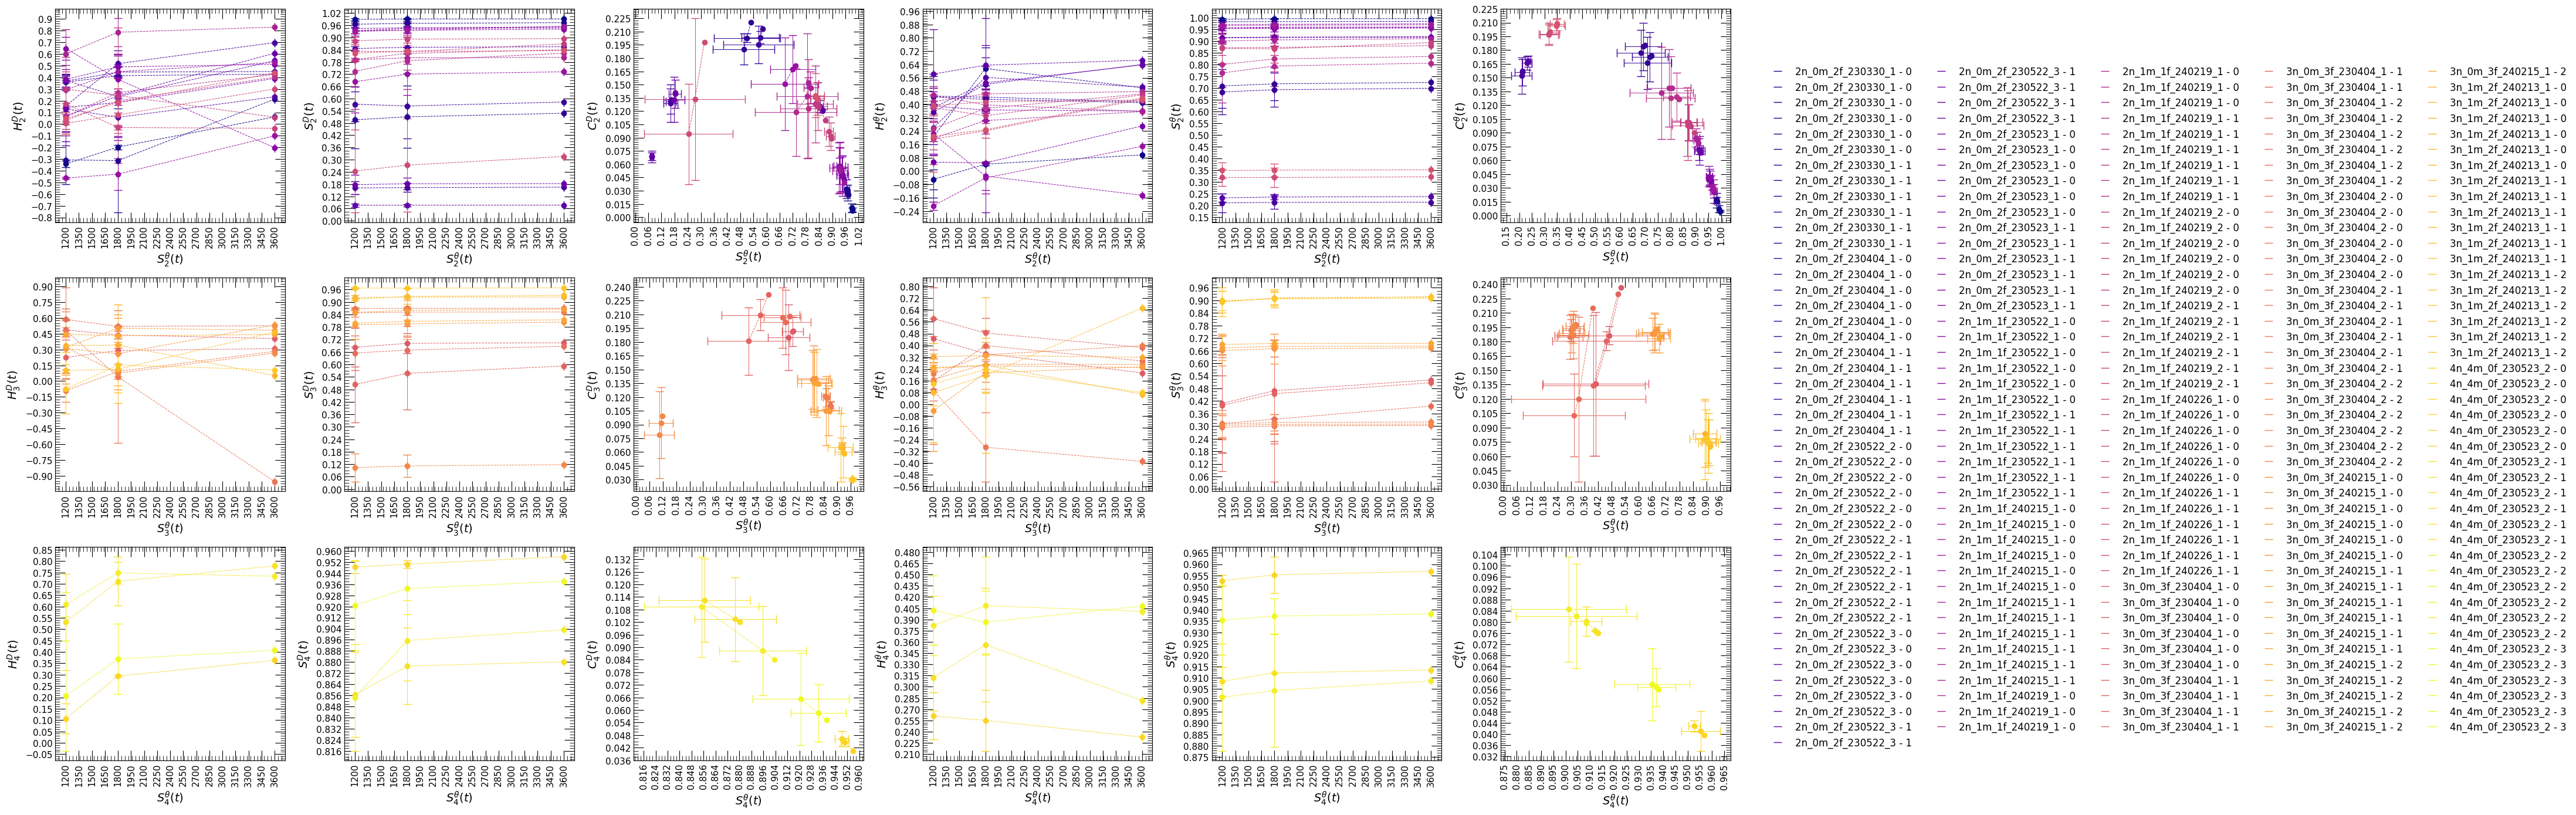

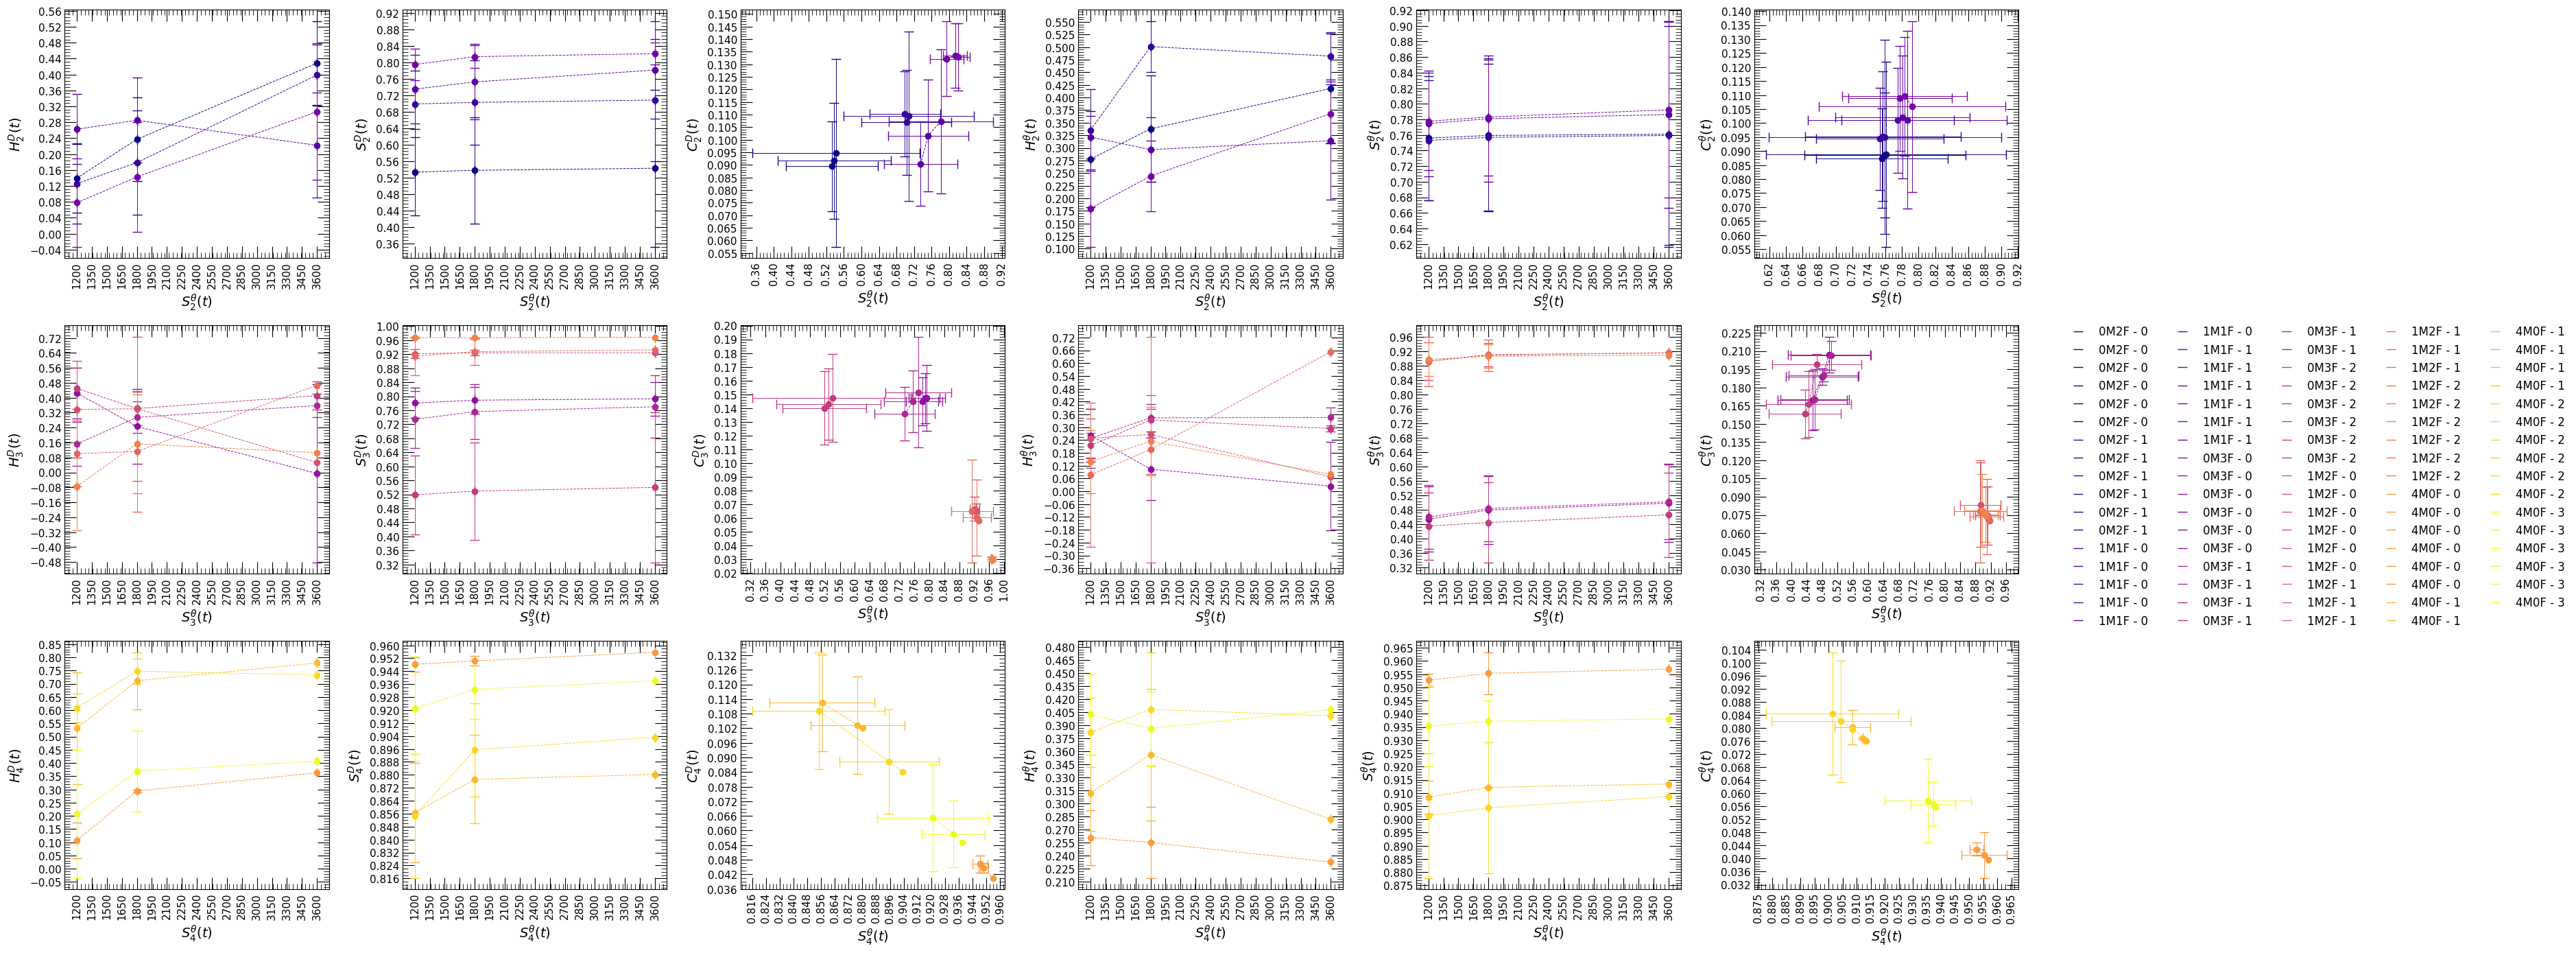

video      t_range  size  permuted_id  H_distance  \
0    2n_0m_2f_230330_1     0 - 1200  1200            0   -0.316029   
1    2n_0m_2f_230330_1     0 - 1200  1200            1    0.042692   
2    2n_0m_2f_230330_1  1200 - 2400  1200            0   -0.314981   
3    2n_0m_2f_230330_1  1200 - 2400  1200            1   -0.681348   
4    2n_0m_2f_230330_1  2400 - 3600  1200            0   -0.394620   
..                 ...          ...   ...          ...         ...   
211  4n_4m_0f_230523_2  1800 - 3600  1800            3    0.214942   
212  4n_4m_0f_230523_2     0 - 3600  3600            0    0.362870   
213  4n_4m_0f_230523_2     0 - 3600  3600            1    0.778787   
214  4n_4m_0f_230523_2     0 - 3600  3600            2    0.733202   
215  4n_4m_0f_230523_2     0 - 3600  3600            3    0.407086   

     PE_distance  C_distance  H_orientation  PE_orientation  C_orientation  \
0       0.979235    0.020101      -0.169366        0.984680       0.014516   
1       0.939758    0.052800       0.493172        0.976648       0.021947   
2       0.997538    0.002408       0.022185        0.998105       0.001882   
3       0.977187    0.021930      -0.521319        0.981434       0.017753   
4       0.990383    0.009240      -0.003803        0.994969       0.004941   
..           ...         ...            ...             ...            ...   
211     0.951226    0.044847       0.343959        0.945015       0.049889   
212     0.955779    0.040500       0.232728        0.956867       0.039692   
213     0.880230    0.102135       0.281743        0.913399       0.076053   
214     0.903201    0.084074       0.400831        0.908576       0.079667   
215     0.938125    0.055203       0.407935        0.938068       0.055864   

    particles sex_ratio  H_distance_count_1  H_distance_mean_1  \
0           2  2n_0m_2f                   3          -0.341877   
1           2  2n_0m_2f                   3          -0.307396   
2           2  2n_0m_2f                   3          -0.341877   
3           2  2n_0m_2f                   3          -0.307396   
4           2  2n_0m_2f                   3          -0.341877   
..        ...       ...                 ...                ...   
211         4  4n_4m_0f                   2           0.369141   
212         4  4n_4m_0f                   1           0.362870   
213         4  4n_4m_0f                   1           0.778787   
214         4  4n_4m_0f                   1           0.733202   
215         4  4n_4m_0f                   1           0.407086   

     H_distance_std_1  H_distance_count_2  H_distance_mean_2  \
0            0.026373                  15           0.139641   
1            0.209353                  15           0.125976   
2            0.026373                  15           0.139641   
3            0.209353                  15           0.125976   
4            0.026373                  15           0.139641   
..                ...                 ...                ...   
211          0.154199                   2           0.369141   
212               NaN                   1           0.362870   
213               NaN                   1           0.778787   
214               NaN                   1           0.733202   
215               NaN                   1           0.407086   

     H_distance_std_2  PE_distance_count_1  PE_distance_mean_1  \
0            0.087253                    3            0.989052   
1            0.099958                    3            0.965196   
2            0.087253                    3            0.989052   
3            0.099958                    3            0.965196   
4            0.087253                    3            0.989052   
..                ...                  ...                 ...   
211          0.154199                    2            0.932832   
212               NaN                    1            0.955779   
213               NaN                    1            0.880230   
214              

In [ ]:
df_complexity_summary, ax_complexity_1, ax_complexity_2 = pc.plot_complexity_metrics_summary(
    df_complexity=df_complexity,
    width=30,
    height=14,
    n_x_breaks=20,
    n_y_breaks=20,
    fancy_legend=False,
    save_figures=False,
    output_path=output_path,
    output_name="plot_gliding_complexity_summary"
)
df_complexity_summary

---
# How different is the behavior when sex ratio changes (fixed group size)?

- Aim: To examine coordination and coupling using Cross-recurrence quantification analysis (CRQA).
- Data: Distances from the center of the box and orientation of the cockroaches respect to the vertical.
---

## Synchronization in Complex Systems

### **Mathematical Formulation**

#### 1. Recurrence Plot Analysis (RPA)

**Recurrence Plot Analysis (RPA)** is a nonlinear method for studying the dynamics and synchronization of complex systems. It visualizes when a system revisits the same or similar state in its phase space.

Given a trajectory $\vec{x}_i \in \mathbb{R}^d$, the **recurrence matrix** is defined as:

\begin{equation}
    R_{i,j} = \Theta(\varepsilon - \|\vec{x}_i - \vec{x}_j\|),
\end{equation}

where:
- $\varepsilon$ is a threshold,
- $\Theta$ is the Heaviside step function,
- $R_{i,j} = 1$ means state $i$ recurs at time $j$.

The resulting binary matrix can be visualized as a **recurrence plot**.

**Recurrence Quantification Analysis (RQA)** converts the visual features of recurrence plots into quantitative metrics:

| Metric | Description |
|--------|-------------|
| **RR** – Recurrence Rate | Ratio of recurrent points in the plot |
| **DET** – Determinism | Fraction of recurrent points forming diagonal lines (indicating predictability) |
| **L** – Average Diagonal Line Length | Mean time over which the system exhibits similar behavior |
| **ENTR** – Entropy | Shannon entropy of diagonal line lengths (complexity measure) |
| **LAM** – Laminarity | Fraction of points forming vertical lines (indicating intermittency or stationarity) |
| **TT** – Trapping Time | Average vertical line length |

These metrics help detect patterns such as synchronization, chaos, and transitions in dynamics.

---

#### 2. Kuramoto Model & Synchronization

The **Kuramoto model** is a classical model for understanding synchronization in populations of coupled oscillators (e.g., neurons, fireflies, mechanical rotors).

Each oscillator $i$ has a phase $\theta_i(t)$, and their interaction is governed by:

\begin{equation}
    \frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^{N} \sin(\theta_j - \theta_i),
\end{equation}

where:
- $\omega_i$ is the natural frequency,
- $K$ is the coupling strength,
- $N$ is the number of oscillators.

The **degree of synchronization** is measured by the **Kuramoto order parameter** $R(t)$:

\begin{equation}
    R(t) = \left| \frac{1}{N} \sum_{j=1}^{N} e^{i \theta_j(t)} \right|
\end{equation}

- $R(t) \in [0, 1]$
- $R(t) \approx 1$: perfect phase synchronization
- $R(t) \approx 0$: desynchronized or incoherent state

This metric summarizes global coherence in the system and is often visualized as a function of time or coupling strength $K$.

The **Kuramoto parameter** offers a global phase measure, while **RQA** captures finer nonlinear structures and local synchrony.

---

In [82]:
df = df_final[df_final["video"].str.startswith("4n")]
Rs, df_metrics = esa.estimate_multiple_crqa(
    df=df,
    epsilon_factor=0.05,
    plot=False,
    min_diagonal_length=2,
    min_vertical_length=2
)
df_metrics

video id_pair        RR       DET         L      ENTR  \
0  4n_4m_0f_230523_2      00  0.040980  0.642626  3.584505  1.602308   
1  4n_4m_0f_230523_2      01  0.010996  0.736587  4.309480  1.807018   
2  4n_4m_0f_230523_2      02  0.012038  0.810862  5.615876  2.169751   
3  4n_4m_0f_230523_2      03  0.012369  0.682305  3.843701  1.567996   
4  4n_4m_0f_230523_2      11  0.042574  0.829699  5.400212  2.033451   
5  4n_4m_0f_230523_2      12  0.016949  0.929726  9.684278  2.709115   
6  4n_4m_0f_230523_2      13  0.013363  0.813852  5.055430  2.020234   
7  4n_4m_0f_230523_2      22  0.048622  0.886045  5.995273  2.254259   
8  4n_4m_0f_230523_2      23  0.013602  0.837301  5.570363  2.137840   
9  4n_4m_0f_230523_2      33  0.065939  0.731598  4.259749  1.850236   

        LAM         TT  num_diag_lines  num_vert_lines  
0  0.798356   4.856437           10597            9717  
1  0.837652   5.063262            2711            2624  
2  0.885676   6.585867            2507            2335  
3  0.805560   4.518076            3167            3181  
4  0.906935   7.760067            9435            7177  
5  0.960404  11.425304            2347            2055  
6  0.891933   6.210983            3103            2768  
7  0.940085   8.620685           10365            7648  
8  0.908507   6.813456            2949            2616  
9  0.850753   6.036705           16335           13404

In [83]:
# Plot recurrence matrix and crqa metrics

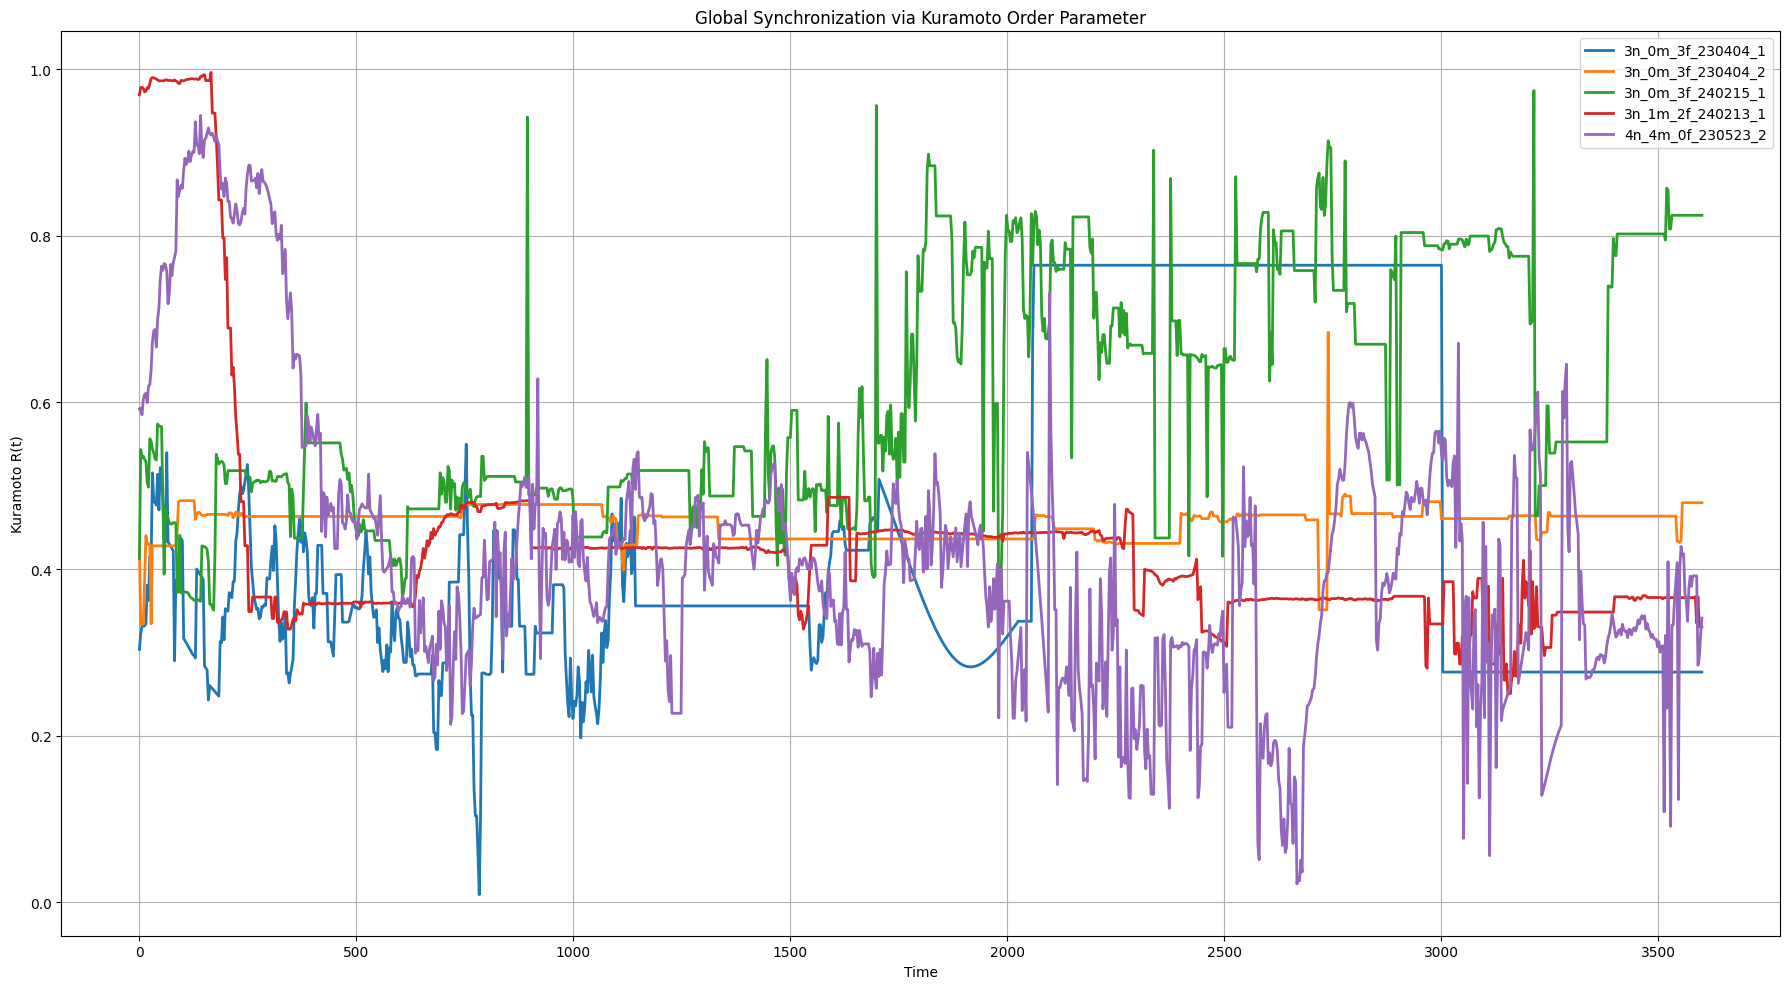

video  time  order_parameter
0     3n_0m_3f_230404_1     0         0.303477
1     3n_0m_3f_230404_1     3         0.322487
2     3n_0m_3f_230404_1     6         0.331615
3     3n_0m_3f_230404_1     9         0.331522
4     3n_0m_3f_230404_1    12         0.331760
...                 ...   ...              ...
6000  4n_4m_0f_230523_2  3588         0.391846
6001  4n_4m_0f_230523_2  3591         0.284494
6002  4n_4m_0f_230523_2  3594         0.293666
6003  4n_4m_0f_230523_2  3597         0.320408
6004  4n_4m_0f_230523_2  3600         0.341211

[6005 rows x 3 columns]

In [ ]:
import matplotlib.pyplot as plt
df_synchronization = []
plt.figure(figsize=(18, 10))
for video in df_final["video"].unique():
    if int(video[0]) > 2:
        mask = df_final["video"] == video
        times, Rs = esa.estimate_kuramoto_order_parameter(df=df_final[mask])
        df_synchronization.append(pd.DataFrame({
            "video": [video]*len(times),
            "time": times,
            "order_parameter": Rs
        }))
        plt.plot(times, Rs, lw=2, label=video)
df_synchronization = pd.concat(df_synchronization, ignore_index=True)

# Plot
plt.xlabel("Time")
plt.ylabel("Kuramoto R(t)")
plt.title("Global Synchronization via Kuramoto Order Parameter")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
df_synchronization

# How different is the behavior with different number of cockroaches?

- Aim: To measure space utilization, e.g., via Shannon entropy or fractal dimension or Dual correlation (HoI).
- Aim (optional): To quantify network properties (modularity, clustering, degree distribution).
- Data: Distances from the center of the box and orientation of the cockroaches respect to the vertical.

## Get Visibility Graph between individuals
The **Visibility Graph** ($VG$) is a method that transforms time series into a complex network, where data points in the series are mapped to nodes and edges are created based on visibility criteria.

### **Mathematical Formulation**
Given a time series $X = \{ x_1, x_2, ..., x_N \}$, two data points $(x_i, t_i)$ and $(x_j, t_j)$ are connected if any intermediate point $(x_k, t_k)$ satisfies:

\begin{equation}
    x_k < x_i + (x_j - x_i) \frac{t_k - t_i}{t_j - t_i}, \quad \forall k \in (i,j)
\end{equation}

In [ ]:
# TODO:
# - Compare same N and same Sex proportion
# - Distribution of resting time using distance threshold
# - How circadian clock affects the cockroaches behaviour
# - Compare mu of power-law for jump length (foraging book)
# - Heterogeneity (Network) is greater than 1 for heavy tails

# Tracked all frames and estimate a proportion of no moving frames
# Explore SINDY Python package
# 5 notebooks:
#   - D = x**2+y**2
#   - d12 = Distances per pairs
#   - Elementary symmetric polynomial
#   - Simulation data -> Decoupled by 2
#   - Summary